In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from googletrans import Translator
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from tqdm import tqdm
from sklearn.model_selection import KFold
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import openpyxl
from tqdm import tqdm  
from googletrans import Translator
# Translation
from tqdm import tqdm  
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
import re
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, OneSidedSelection, InstanceHardnessThreshold
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import numpy as np
from sklearn.model_selection import KFold
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from bidi.algorithm import get_display

[nltk_data] Downloading package stopwords to C:\Users\Hasibul
[nltk_data]     Hamim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Hasibul
[nltk_data]     Hamim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load Data
wb = openpyxl.load_workbook('E:/Research_Work/Bangla_CyberBulling_2024/Code & dataset/dataset/Final_Dataset_94k_Bangla_CyberBulling_Combine_Dataset_94k.xlsx')
ws = wb['Sheet1']
data_rows = []
for row in ws['A1':'B94001']:
    data_cols = [cell.value for cell in row]
    data_rows.append(data_cols)
df = pd.DataFrame(data_rows)
header = df.iloc[0]
df.columns = [header]
df = df.iloc[1:, :]

C:\Users\Hasibul Hamim\AppData\Local\Temp\ipykernel_23024\4283850373.py:10: DeprecationWarning: Series._data is deprecated and will be removed in a future version. Use public APIs instead.
  df.columns = [header]


In [3]:
class_counts = df['label'].value_counts()
print("Class Counts:\n", class_counts)

Class Counts:
 (label,) 
not bully    33579
troll        23193
sexual       18026
religious    15424
threat        3778
Name: count, dtype: int64


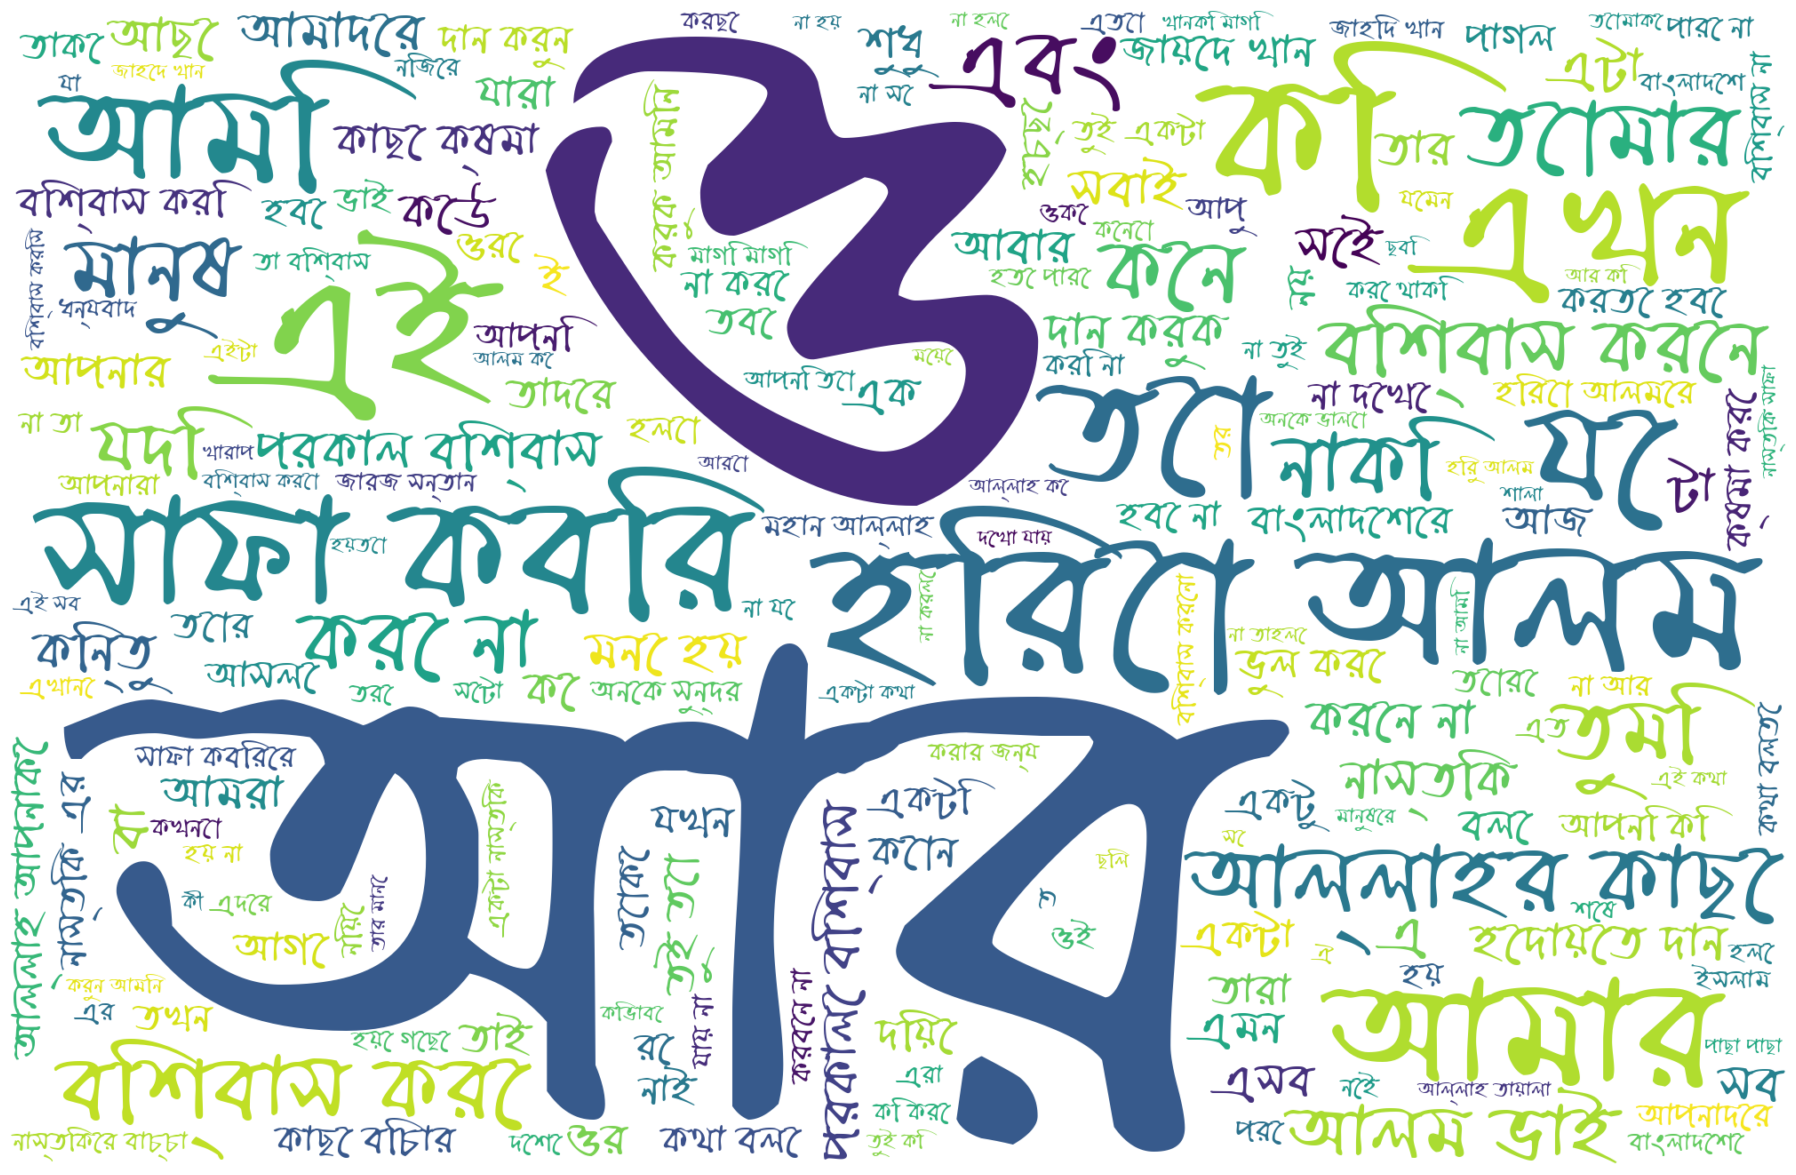

In [4]:
all_comments = ' '.join(df['comment'].apply(lambda x: ' '.join(map(str, x))).astype(str))

rgx = r"[\u0980-\u09FF]+"
wordcloud = WordCloud(font_path='E:/Research_Work/Bangla_CyberBulling_2024/Code & dataset/Dataset/Font/CHANO___.ttf',regexp=rgx, width=2000, height=1300, background_color='white').generate(all_comments)

plt.figure(figsize=(30, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [5]:
# Data Exploration
print(df.head())
print(df.iloc[:, -1].value_counts())
print(df.shape)
print(df.isna().sum())

# Handle Missing Values
mode = df.iloc[:, -2].value_counts().index[0]
df.iloc[:, -2].fillna(mode, inplace=True)
print(df.isna().sum())
print(df.head())

0                                            comment      label
1  হয়তো ❤ আয়মান ভাইয়ের পেইজের এডমিন $% মুনজেরিন আ...      troll
2              এতো :) আমাদের জন্য বড় # আনন্দের সংবাদ      troll
3  >এজন্যই বলি আ-লীগে ❤ চলে আসুন। সব নির্বাচন-ই স...  not bully
4  এটিএম :) কার্ড দেখিয়ে স্টুডেন্ট # হাফপাস নেওয়া...      troll
5                       > আমাদের জীবনে কোম সিজি নাই?      troll
(label,)
not bully    33579
troll        23193
sexual       18026
religious    15424
threat        3778
Name: count, dtype: int64
(94000, 2)
comment    0
label      0
dtype: int64
comment    0
label      0
dtype: int64
0                                            comment      label
1  হয়তো ❤ আয়মান ভাইয়ের পেইজের এডমিন $% মুনজেরিন আ...      troll
2              এতো :) আমাদের জন্য বড় # আনন্দের সংবাদ      troll
3  >এজন্যই বলি আ-লীগে ❤ চলে আসুন। সব নির্বাচন-ই স...  not bully
4  এটিএম :) কার্ড দেখিয়ে স্টুডেন্ট # হাফপাস নেওয়া...      troll
5                       > আমাদের জীবনে কোম সিজি নাই?      troll


In [6]:
# Labeling and Encoding
list(df.iloc[:, -1].value_counts().index)
df['nlabel'] = df.label.replace(['not bully', 'troll', 'sexual', 'religious', 'threat'], [0, 1, 2, 3, 4])
df['noutput'] = df.iloc[:, -1].replace(['bully', 'normal'], [1, 0])
print(df.head())
print(df.head())

0                                            comment      label nlabel noutput
1  হয়তো ❤ আয়মান ভাইয়ের পেইজের এডমিন $% মুনজেরিন আ...      troll      1       1
2              এতো :) আমাদের জন্য বড় # আনন্দের সংবাদ      troll      1       1
3  >এজন্যই বলি আ-লীগে ❤ চলে আসুন। সব নির্বাচন-ই স...  not bully      0       0
4  এটিএম :) কার্ড দেখিয়ে স্টুডেন্ট # হাফপাস নেওয়া...      troll      1       1
5                       > আমাদের জীবনে কোম সিজি নাই?      troll      1       1
0                                            comment      label nlabel noutput
1  হয়তো ❤ আয়মান ভাইয়ের পেইজের এডমিন $% মুনজেরিন আ...      troll      1       1
2              এতো :) আমাদের জন্য বড় # আনন্দের সংবাদ      troll      1       1
3  >এজন্যই বলি আ-লীগে ❤ চলে আসুন। সব নির্বাচন-ই স...  not bully      0       0
4  এটিএম :) কার্ড দেখিয়ে স্টুডেন্ট # হাফপাস নেওয়া...      troll      1       1
5                       > আমাদের জীবনে কোম সিজি নাই?      troll      1       1


In [7]:
translator = Translator()
output = []

for i in tqdm(range(len(df))):
    if df.label.values[i] == 'not bully':
        output.append('Normal')
    else:
        output.append('Bully')

df['output'] = output
df['noutput'] = df.iloc[:, -1].replace(['Bully', 'Normal'], [1, 0])


100%|██████████| 94000/94000 [01:12<00:00, 1299.03it/s]


In [8]:
df['comment']

,comment
1,হয়তো ❤ আয়মান ভাইয়ের পেইজের এডমিন $% মুনজেরিন আ...
2,এতো :) আমাদের জন্য বড় # আনন্দের সংবাদ
3,>এজন্যই বলি আ-লীগে ❤ চলে আসুন। সব নির্বাচন-ই স...
4,এটিএম :) কার্ড দেখিয়ে স্টুডেন্ট # হাফপাস নেওয়া...
5,> আমাদের জীবনে কোম সিজি নাই?
...,...
93996,"হিরো আলম,, এগিয়ে যাও"
93997,হিরো আলমকে সাপোর্ট দেওয়ার জন্য অসংখ্য ধন্যবাদ...
93998,হিরো ভাই তুমি এগিয়ে য়াও
93999,হুম ভাও তোমরা এগিয়ে যাও আমরা তোমাদের পিছনে আছি


In [9]:
df.to_csv('v1.csv')

In [10]:
print(stopwords.fileids())
sw = stopwords.words('bengali')

new_stopwords = stopwords.words('english')
new_stopwords.append('SampleWord')

df.to_csv('df_english1000.csv')

nltk.download('wordnet')
nltk.download('omw-1.4')

wordnet_lemmatizer = WordNetLemmatizer()

M = len(df)
for k in tqdm(range(M)):
    text = df.iloc[:, 0].values[k]
    txt = re.sub(r'http\S+', '', text)
    txt = re.sub(r'[!@#$%^&*?><,./\-+`~|:);(❤}{]', '', txt)

    text_tokens = word_tokenize(txt)

    def detect_benglish(text_tokens):
        benglish = False
        for j in range(len(text_tokens)):
            for i in range(len(text_tokens[j])):
                detector = Translator()
                txt = text_tokens[j]
                if i < len(txt) - 1:
                    if detector.detect(txt[i]).lang == 'bn' and detector.detect(txt[i + 1]).lang == 'en' and txt[
                        i].isalpha() == True and txt[i + 1].isalpha() == True:
                        benglish = True
        return benglish

    def handle_benglish(text_tokens):
        for j in range(len(text_tokens)):
            s = []
            for i in range(len(text_tokens[j])):
                detector = Translator()
                txt = text_tokens[j]
                if i < len(txt) - 1:
                    if detector.detect(txt[i]).lang == 'bn' and detector.detect(txt[i + 1]).lang == 'en' and txt[
                        i].isalpha() == True and txt[i + 1].isalpha() == True:
                        s.append(i)
                    if txt[i] == '|':
                        s.append(i)
            for i in range(len(s)):
                txt = txt.replace(txt[s[i]], txt[s[i]] + " ")
            text_tokens[j] = txt
        tstring = str(' '.join(text_tokens)).lower()
        text_tokens = word_tokenize(tstring)
        return text_tokens

    remove_sw = [word for word in text_tokens if not word in sw]
    un_items = np.unique(remove_sw)
    r_sw = [wordnet_lemmatizer.lemmatize(w) for w in un_items]
    bn_tokens = []

    def tanslate_bengali(r_sw):
        for i in range(len(r_sw)):
            bn_tokens.append(translator.translate(r_sw[i], dest='bn').text)
        return bn_tokens

    bn_token = r_sw
    df.iloc[:, 0].values[k] = ' '.join(bn_token)

df.iloc[:, -1].value_counts()
df.iloc[:, 0]

df[:].iloc[:, 0].shape


['arabic', 'azerbaijani', 'basque', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


[nltk_data] Downloading package wordnet to C:\Users\Hasibul
[nltk_data]     Hamim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Hasibul
[nltk_data]     Hamim\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 94000/94000 [00:44<00:00, 2099.59it/s]


(94000,)

In [23]:
# Text Vectorization (Count)

count_vectorizer = CountVectorizer(max_features=20000, tokenizer=word_tokenize, stop_words=stopwords.words('english'))
iX_count = count_vectorizer.fit_transform(df[:].iloc[:, 0].values).toarray()

c:\Users\Hasibul Hamim\anaconda3\envs\tf\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Hasibul Hamim\anaconda3\envs\tf\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [13]:
tfidf_vectorizer = TfidfTransformer()
tf_transformer = TfidfTransformer(use_idf=True).fit(iX_count)
iX_tfidf = tf_transformer.transform(iX_count)
iX_tfidf.shape

(94000, 20000)

In [15]:
by = df.iloc[:, -3].values
by.shape

my = df.iloc[:, -1].values

np.unique(by)

array([0, 1, 2, 3, 4], dtype=int64)

In [16]:
# Imbalanced Data Handling
cc = InstanceHardnessThreshold(random_state=10, estimator=LogisticRegression())
X, y = cc.fit_resample(iX_tfidf, by)
X.shape, y.shape

c:\Users\Hasibul Hamim\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Hasibul Hamim\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

((18890, 20000), (18890,))

In [55]:
# Cross-Validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in kf.split(iX_tfidf, by):
    X_train, X_test = iX_tfidf[train_index], iX_tfidf[test_index]
    y_train, y_test = by[train_index], by[test_index]
print('complete')
print('train:', X_train.shape, y_train.shape, 'test:', X_test.shape, y_test.shape)

complete
train: (75200, 20000) (75200,) test: (18800, 20000) (18800,)


In [18]:
# Cross-Validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
print('complete')
print('train:', X_train.shape, y_train.shape, 'test:', X_test.shape, y_test.shape)

complete
train: (15112, 20000) (15112,) test: (3778, 20000) (3778,)


Building Stacking Classifier model...
Stacking Classifier model built successfully.
Accuracy: 92.32%
Precision: 92.47%
Recall: 92.32%
F1 Score: 92.32%


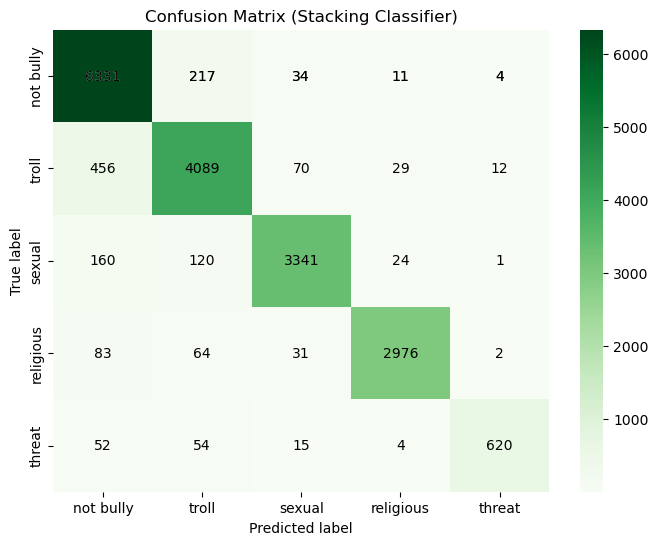

In [56]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import is_classifier

# Assuming you have X_train, X_test, y_train, y_test defined somewhere in your code
# Part 51: Model Building (Stacking Classifier: SGD, MLP, RandomForest)
def build_stacking_classifier(X_train, y_train):
    global stacking_model
    print('Building Stacking Classifier model...')
    # Creating instances of the base classifiers
    sgd_classifier = SGDClassifier()
    mlp_classifier = MLPClassifier()
    rf_classifier = RandomForestClassifier()
    # Check if classifiers support probability estimates
    classifiers_with_proba = [(name, clf) for name, clf in [('sgd', sgd_classifier), ('mlp', mlp_classifier), ('rf', rf_classifier)] if is_classifier(clf) and hasattr(clf, "predict_proba")]
    if not classifiers_with_proba:
        raise ValueError("None of the base classifiers support probability estimates. Stacking requires probability estimates.")

    # Creating the Stacking Classifier
    stacking_model = StackingClassifier(classifiers_with_proba, final_estimator=RandomForestClassifier(), stack_method='auto', n_jobs=-1)
    
    # Fitting the model
    stacking_model.fit(X_train, y_train)
    print('Stacking Classifier model built successfully.')
    return stacking_model
# Building the Stacking Classifier (assuming X_train, X_test, y_train, y_test are defined)
stacking_model = build_stacking_classifier(X_train, y_train)

# Part 52: Model Evaluation (Stacking Classifier)
def evaluate_stacking_classifier(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {acc*100:.2f}%')
    
    # Additional metrics
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'Precision: {precision*100:.2f}%')
    print(f'Recall: {recall*100:.2f}%')
    print(f'F1 Score: {f1*100:.2f}%')
    
    confusion_matrix_analysis(model, X_test, y_test)
    
    return acc

# Part 53: Confusion Matrix Analysis (Stacking Classifier)
def confusion_matrix_analysis(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    class_names = ['not bully', 'troll', 'sexual', 'religious', 'threat']  # Update class names
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
    
    # Display values on the plot without box and color
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j + 0.5, i + 0.5, f'{cm[i, j]}', ha='center', va='center', color='black', fontsize=10)

    plt.title('Confusion Matrix (Stacking Classifier)')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Evaluating the Stacking Classifier
accuracy_stacking = evaluate_stacking_classifier(stacking_model, X_test, y_test)

In [57]:
import pickle
with open("model.pkl", "wb") as model_file:
        pickle.dump((stacking_model, count_vectorizer, tf_transformer, y), model_file)


In [64]:
# ... (rest of the preprocessing code)

# Assuming the 'stacking_model' is defined from your previous code

# Your Bangla text for testing
bangla_text = "রুপে আগুন থাকলে আজ এত শীত লাগতো না"


# Preprocess the Bangla text
def preprocess_bangla_text(text):
    txt = re.sub(r'http\S+', '', text)
    txt = re.sub(r'[!@#$%^&*?><,./\-+`~|:);(❤}{]', '', txt)

    text_tokens = word_tokenize(txt)

    def detect_benglish(text_tokens):
        benglish = False
        for j in range(len(text_tokens)):
            for i in range(len(text_tokens[j])):
                detector = Translator()
                txt = text_tokens[j]
                if i < len(txt) - 1:
                    if detector.detect(txt[i]).lang == 'bn' and detector.detect(txt[i + 1]).lang == 'en' and txt[i].isalpha() == True and txt[i + 1].isalpha() == True:
                        benglish = True
        return benglish

    def handle_benglish(text_tokens):
        for j in range(len(text_tokens)):
            s = []
            for i in range(len(text_tokens[j])):
                detector = Translator()
                txt = text_tokens[j]
                if i < len(txt) - 1:
                    if detector.detect(txt[i]).lang == 'bn' and detector.detect(txt[i + 1]).lang == 'en' and txt[i].isalpha() == True and txt[i + 1].isalpha() == True:
                        s.append(i)
                    if txt[i] == '|':
                        s.append(i)
            for i in range(len(s)):
                txt = txt.replace(txt[s[i]], txt[s[i]] + " ")
            text_tokens[j] = txt
        tstring = str(' '.join(text_tokens)).lower()
        text_tokens = word_tokenize(tstring)
        return text_tokens

    remove_sw = [word for word in text_tokens if not word in sw]
    un_items = np.unique(remove_sw)
    r_sw = [wordnet_lemmatizer.lemmatize(w) for w in un_items]
    bn_tokens = []

    def tanslate_bengali(r_sw):
        for i in range(len(r_sw)):
            bn_tokens.append(translator.translate(r_sw[i], dest='bn').text)
        return bn_tokens

    bn_token = r_sw
    preprocessed_text = ' '.join(bn_token)

    return preprocessed_text

# Vectorize the preprocessed Bangla text
def vectorize_bangla_text(text):
    vectorized_text = count_vectorizer.transform([text]).toarray()
    tfidf_vectorizer = TfidfTransformer()
    vectorized_text = tfidf_vectorizer.fit_transform(vectorized_text).toarray()
    return vectorized_text

# Preprocess and vectorize the Bangla text
preprocessed_text = preprocess_bangla_text(bangla_text)
vectorized_text = vectorize_bangla_text(preprocessed_text)

# Reshape the vectorized text to match the input shape during training
vectorized_text = vectorized_text.reshape(1, -1)

# Use the trained stacking model to predict the class
predicted_class = stacking_model.predict(vectorized_text)

# Print the predicted class
print("Predicted Class:", predicted_class)


Predicted Class: [2]
